# Use Off-Policy VPG to Play CartPole-v0

PyTorch version

In [1]:
%matplotlib inline

import sys
import logging
import itertools

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as distributions
torch.manual_seed(0)

logging.basicConfig(level=logging.INFO,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

In [2]:
env = gym.make('CartPole-v0', new_step_api=True)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

22:54:44 [INFO] env: <CartPoleEnv<CartPole-v0>>
22:54:44 [INFO] action_space: Discrete(2)
22:54:44 [INFO] observation_space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
22:54:44 [INFO] reward_range: (-inf, inf)
22:54:44 [INFO] metadata: {'render.modes': ['human', 'rgb_array'], 'video.frames_per_second': 50}
22:54:44 [INFO] _max_episode_steps: 200
22:54:44 [INFO] _elapsed_steps: None
22:54:44 [INFO] id: CartPole-v0
22:54:44 [INFO] entry_point: gym.envs.classic_control:CartPoleEnv
22:54:44 [INFO] reward_threshold: 195.0
22:54:44 [INFO] nondeterministic: False
22:54:44 [INFO] max_episode_steps: 200
22:54:44 [INFO] _kwargs: {}
22:54:44 [INFO] _env_name: CartPole


In [3]:
class OffPolicyVPGAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        self.gamma = 0.99

        self.policy_net = self.build_net(
                input_size=env.observation_space.shape[0],
                hidden_sizes=[],
                output_size=self.action_n, output_activator=nn.Softmax(1))
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=0.06)

    def build_net(self, input_size, hidden_sizes, output_size,
            output_activator=None, use_bias=False):
        layers = []
        for input_size, output_size in zip(
                [input_size,] + hidden_sizes, hidden_sizes + [output_size,]):
            layers.append(nn.Linear(input_size, output_size, bias=use_bias))
            layers.append(nn.ReLU())
        layers = layers[:-1]
        if output_activator:
            layers.append(output_activator)
        model = nn.Sequential(*layers)
        return model

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, termination):
        if self.mode == 'train':
            action = np.random.choice(self.action_n) # use random policy
            self.trajectory += [observation, reward, termination, action]
        else:
            state_tensor = torch.as_tensor(observation,
                    dtype=torch.float).unsqueeze(0)
            prob_tensor = self.policy_net(state_tensor)
            action_tensor = distributions.Categorical(prob_tensor).sample()
            action = action_tensor.numpy()[0]
        return action

    def close(self):
        if self.mode == 'train':
            self.learn()

    def learn(self):
        state_tensor = torch.as_tensor(self.trajectory[0::4], dtype=torch.float)
        reward_tensor = torch.as_tensor(self.trajectory[1::4], dtype=torch.float)
        action_tensor = torch.as_tensor(self.trajectory[3::4], dtype=torch.long)
        arange_tensor = torch.arange(state_tensor.shape[0], dtype=torch.float)
        discount_tensor = self.gamma ** arange_tensor
        discounted_reward_tensor = discount_tensor * reward_tensor
        discounted_return_tensor = discounted_reward_tensor.flip(0).cumsum(0).flip(0)
        all_pi_tensor = self.policy_net(state_tensor)
        pi_tensor = torch.gather(all_pi_tensor, 1,
                action_tensor.unsqueeze(1)).squeeze(1)
        behavior_prob = 1. / self.action_n
        loss_tensor = -(discounted_return_tensor / behavior_prob *
                pi_tensor).mean()
        self.optimizer.zero_grad()
        loss_tensor.backward()
        self.optimizer.step()


agent = OffPolicyVPGAgent(env)

22:54:44 [INFO] ==== train ====
22:54:45 [INFO] train episode 0: reward = 30.00, steps = 30
22:54:45 [INFO] train episode 1: reward = 71.00, steps = 71
22:54:45 [INFO] train episode 2: reward = 42.00, steps = 42
22:54:45 [INFO] train episode 3: reward = 18.00, steps = 18
22:54:45 [INFO] train episode 4: reward = 26.00, steps = 26
22:54:45 [INFO] train episode 5: reward = 19.00, steps = 19
22:54:45 [INFO] train episode 6: reward = 15.00, steps = 15
22:54:45 [INFO] train episode 7: reward = 66.00, steps = 66
22:54:45 [INFO] train episode 8: reward = 21.00, steps = 21
22:54:45 [INFO] train episode 9: reward = 64.00, steps = 64
22:54:45 [INFO] train episode 10: reward = 31.00, steps = 31
22:54:45 [INFO] train episode 11: reward = 38.00, steps = 38
22:54:45 [INFO] train episode 12: reward = 36.00, steps = 36
22:54:45 [INFO] train episode 13: reward = 13.00, steps = 13
22:54:45 [INFO] train episode 14: reward = 21.00, steps = 21
22:54:45 [INFO] train episode 15: reward = 16.00, steps = 16
22

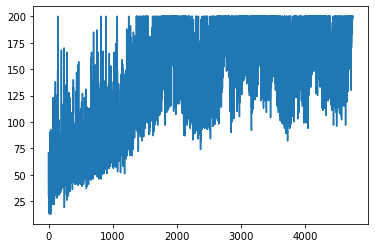

In [4]:
def play_episode(env, agent, seed=None, mode=None, render=False):
    observation = env.reset(seed=seed)
    reward, termination, truncation = 0., False, False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, termination)
        if render:
            env.render()
        if termination or truncation:
            break
        observation, reward, termination, truncation, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    play_episode(env, agent, seed=episode,
            mode='train')
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.info('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-20:]) > 199:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.info('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

In [5]:
env.close()